# Step 2 Dengue Nowcasting (Train/Test Split)

This notebook extends the original Step 2 mixed-lag ARX workflow by:

A fixed train-test split:
   - Train: WHO months up to and including 2025-04
   - Test: WHO months after 2025-04

You can toggle the controls in `cfg`.


In [1]:
# If needed, install dependencies in your environment:
# pip install -U pandas numpy scikit-learn matplotlib

import os
from dataclasses import dataclass
from typing import Tuple, Iterable, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, Ridge, Lasso, LinearRegression, HuberRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
@dataclass
class Step2Config:
    # Inputs
    data_path: str = 'master_data.csv'
    step1_predictions_path: str = os.path.join('outputs_step1', 'predictions_step1_monthly.csv')
    step1_pred_col: str = 'x_pred'  # if not found, first column containing 'pred' is used

    # Target/source names in master_data.csv
    target_source: str = 'WHO'

    # Exogenous signals
    google_sources: Tuple[str, str] = (
        'Google_Trends_Dengue_fever',
        'Google_Trends_Dengue_vaccine',
    )

    # Feature engineering
    lags_y: Tuple[int, ...] = (1, 2)
    use_month_dummies: bool = True

    # Train-test split
    split_month: str = '2025-04'  # train <= split_month, test > split_month

    # Multicollinearity controls
    use_corr_filter: bool = True
    corr_threshold: float = 0.9

    # PCA
    use_pca: bool = False
    pca_variance: float = 0.95

    # Regressor choice
    regressor_name: str = 'ElasticNet'  # ElasticNet/Ridge/Lasso/OLS/Huber

    # Default regressor params (used if not tuning)
    alpha: float = 0.05
    l1_ratio: float = 0.3
    random_state: int = 42
    max_iter: int = 20000

    ridge_alpha: float = 10.0
    lasso_alpha: float = 0.01
    huber_epsilon: float = 1.35
    huber_alpha: float = 0.0001

    # Hyperparameter tuning within training set
    tune_hyperparams: bool = True
    n_splits_cv: int = 4

    # Rolling / expanding choice for CV (set rolling_window_len to an int for rolling)
    rolling_window_len: Optional[int] = None


cfg = Step2Config(
    data_path='master_data.csv',
    step1_predictions_path=os.path.join('outputs_step1', 'predictions_step1_monthly.csv'),
    regressor_name='ElasticNet',
    use_corr_filter=True,
    corr_threshold=0.9,
    use_pca=False,
    pca_variance=0.95,
    tune_hyperparams=True,
)
cfg


Step2Config(data_path='master_data.csv', step1_predictions_path='outputs_step1/predictions_step1_monthly.csv', step1_pred_col='x_pred', target_source='WHO', google_sources=('Google_Trends_Dengue_fever', 'Google_Trends_Dengue_vaccine'), lags_y=(1, 2), use_month_dummies=True, split_month='2025-04', use_corr_filter=True, corr_threshold=0.9, use_pca=False, pca_variance=0.95, regressor_name='ElasticNet', alpha=0.05, l1_ratio=0.3, random_state=42, max_iter=20000, ridge_alpha=10.0, lasso_alpha=0.01, huber_epsilon=1.35, huber_alpha=0.0001, tune_hyperparams=True, n_splits_cv=4, rolling_window_len=None)

In [3]:
def ensure_outdir(path: str) -> None:
    os.makedirs(path, exist_ok=True)


def parse_monthly_date_any(s: pd.Series) -> pd.Series:
    # Accept 'YYYY-MM', 'YYYY-MM-01', or full date; coerce to month-start timestamp.
    x = s.astype(str)
    is_ym = x.str.match('^[0-9]{4}-[0-9]{2}$')
    x = np.where(is_ym, x + '-01', x)
    dt = pd.to_datetime(x, errors='coerce')
    return dt


def load_monthly_wide_from_master(cfg: Step2Config) -> pd.DataFrame:
    df = pd.read_csv(cfg.data_path)
    need = {'resolution', 'date', 'value', 'source'}
    missing = need - set(df.columns)
    if missing:
        raise ValueError(f"{cfg.data_path} missing columns: {sorted(missing)}")

    df = df[df['resolution'].astype(str).str.lower().eq('monthly')].copy()
    df['date'] = parse_monthly_date_any(df['date'])
    df = df.dropna(subset=['date']).copy()

    wide = (
        df.pivot_table(index='date', columns='source', values='value', aggfunc='mean')
        .sort_index()
    )
    return wide


def load_step1_predictions_optional(cfg: Step2Config) -> pd.Series:
    if not os.path.exists(cfg.step1_predictions_path):
        # Return empty series; downstream will fall back to using WHO where available.
        return pd.Series(dtype=float)

    s1 = pd.read_csv(cfg.step1_predictions_path)
    if 'date' not in s1.columns:
        raise ValueError(f"Step 1 predictions file missing 'date' column: {cfg.step1_predictions_path}")

    s1['date'] = parse_monthly_date_any(s1['date'])
    s1 = s1.dropna(subset=['date']).copy()
    s1 = s1.sort_values('date')

    col = cfg.step1_pred_col if cfg.step1_pred_col in s1.columns else None
    if col is None:
        cand = [c for c in s1.columns if 'pred' in c.lower()]
        if not cand:
            # Fallback to the first non-date column
            cand = [c for c in s1.columns if c != 'date']
        if not cand:
            raise ValueError('No prediction column found in Step 1 predictions file.')
        col = cand[0]

    ser = s1.set_index('date')[col].astype(float)
    return ser


def add_month_dummies(X: pd.DataFrame) -> pd.DataFrame:
    dt = pd.to_datetime(X.index)
    m = pd.get_dummies(dt.month, prefix='m', drop_first=True)  # January baseline
    m.index = X.index
    return pd.concat([X, m.astype(float)], axis=1)


def build_features_and_target(wide: pd.DataFrame, cfg: Step2Config) -> tuple[pd.DataFrame, pd.Series]:
    target = cfg.target_source
    if target not in wide.columns:
        raise ValueError(
            f"Target '{target}' not found. Available columns (first 30): {list(wide.columns)[:30]}"
        )

    g1, g2 = cfg.google_sources
    for g in [g1, g2]:
        if g not in wide.columns:
            raise ValueError(
                f"Required Google source '{g}' not found. Available columns (first 30): {list(wide.columns)[:30]}"
            )

    y = wide[target].copy()  # WHO observed (NaN where missing)

    # x_tilde: use WHO where observed, else Step1 estimate if available
    if 'STEP1_est' in wide.columns and wide['STEP1_est'].notna().any():
        x_tilde = y.where(y.notna(), wide['STEP1_est'])
    else:
        x_tilde = y.copy()

    X = pd.DataFrame(index=wide.index)
    X[g1] = wide[g1]
    X[g2] = wide[g2]

    for k in cfg.lags_y:
        X[f'x_tilde_lag{k}'] = x_tilde.shift(k)

    if cfg.use_month_dummies:
        X = add_month_dummies(X)

    X = X.dropna(axis=1, how='all')
    return X, y


In [4]:
def compute_rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


def safe_mape(y_true, y_pred) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(np.abs(y_true) < 1e-12, np.nan, np.abs(y_true))
    return float(np.nanmean(np.abs((y_true - y_pred) / denom)) * 100.0)


def get_regressor(cfg: Step2Config):
    name = (cfg.regressor_name or 'ElasticNet').strip().lower()
    if name in ['elasticnet', 'en']:
        return ElasticNet(alpha=cfg.alpha, l1_ratio=cfg.l1_ratio, random_state=cfg.random_state, max_iter=cfg.max_iter)
    if name in ['ridge']:
        return Ridge(alpha=float(cfg.ridge_alpha))
    if name in ['lasso']:
        return Lasso(alpha=float(cfg.lasso_alpha), random_state=cfg.random_state, max_iter=cfg.max_iter)
    if name in ['ols', 'linear', 'linearregression']:
        return LinearRegression()
    if name in ['huber', 'huberregressor']:
        return HuberRegressor(epsilon=float(cfg.huber_epsilon), alpha=float(cfg.huber_alpha), max_iter=cfg.max_iter)
    raise ValueError(f"Unknown regressor_name: {cfg.regressor_name}")


def make_pipeline(cfg: Step2Config, n_components_pca: Optional[int] = None) -> Pipeline:
    steps = [
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler()),
    ]
    if cfg.use_pca:
        if n_components_pca is None:
            steps.append(('pca', PCA(n_components=cfg.pca_variance, svd_solver='full')))
        else:
            steps.append(('pca', PCA(n_components=n_components_pca, svd_solver='full')))

    steps.append(('reg', get_regressor(cfg)))
    return Pipeline(steps)


def time_series_split_indices(index: pd.DatetimeIndex, split_month: str):
    split_dt = pd.to_datetime(split_month + '-01')
    train_mask = index <= split_dt
    test_mask = index > split_dt
    return train_mask, test_mask


## 1) Load data, merge Step 1 predictions, build raw features

Notes:
- This step reproduces the original Step 2 feature construction: Google trends + lagged x_tilde.
- If Step 1 predictions are missing, the code will still run for the WHO-observed months (x_tilde = WHO).


In [5]:
wide = load_monthly_wide_from_master(cfg)

# Optional Step 1 predictions
step1_ser = load_step1_predictions_optional(cfg)
wide = wide.copy()
wide['STEP1_est'] = step1_ser.reindex(wide.index)

X_raw, y_raw = build_features_and_target(wide, cfg)

# Keep only months where WHO is observed (target available)
mask_obs = y_raw.notna()
X = X_raw.loc[mask_obs].copy()
y = y_raw.loc[mask_obs].astype(float).copy()

print('Raw X shape:', X.shape)
print('WHO observed months:', len(y))
X.head()


Raw X shape: (22, 15)
WHO observed months: 22


,Google_Trends_Dengue_fever,Google_Trends_Dengue_vaccine,x_tilde_lag1,x_tilde_lag2,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
date,,,,,,,,,,,,,,,
2024-01-01,12.0,34.0,17365.751953,36022.085938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-02-01,11.0,38.0,5079.000000,17365.751953,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-01,9.0,23.0,5429.000000,5079.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-04-01,9.0,26.0,5597.000000,5429.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-05-01,11.0,38.0,3342.000000,5597.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# No autocorrelation diagnostics/differencing in this version
X_proc = X.copy()
y_proc = y.copy()


## 2) Model training and evaluation (Train: <= 2025-04; Test: > 2025-04)

We train a regression model and evaluate on the held-out test period.

If `cfg.tune_hyperparams=True`, we tune within the training set using `TimeSeriesSplit`.


In [7]:
# --- Train/test split (time-based) + optional correlation filter ---

# Ensure numeric dtypes
X_proc = X_proc.apply(pd.to_numeric, errors='coerce')
y_proc = pd.to_numeric(y_proc, errors='coerce')

train_mask, test_mask = time_series_split_indices(X_proc.index, cfg.split_month)
X_train, y_train = X_proc.loc[train_mask].copy(), y_proc.loc[train_mask].copy()
X_test, y_test = X_proc.loc[test_mask].copy(), y_proc.loc[test_mask].copy()

if len(X_train) < 5:
    raise ValueError(f"Training set too small (n={len(X_train)}). Consider moving cfg.split_month earlier.")
if len(X_test) < 1:
    raise ValueError("Test set is empty. Consider moving cfg.split_month earlier.")

# (Optional) drop rows where lag features are missing (happens at the very start due to shifting)
lag_cols = [f'x_tilde_lag{k}' for k in (cfg.lags_y or ())]
if lag_cols:
    ok = X_proc[lag_cols].notna().all(axis=1)
    X_train, y_train = X_train.loc[ok.reindex(X_train.index, fill_value=False)], y_train.loc[ok.reindex(y_train.index, fill_value=False)]
    X_test, y_test = X_test.loc[ok.reindex(X_test.index, fill_value=False)], y_test.loc[ok.reindex(y_test.index, fill_value=False)]

# (Optional) correlation filter computed on TRAIN only to avoid leakage
if cfg.use_corr_filter:
    corr = X_train.corr(numeric_only=True).abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop_cols = [c for c in upper.columns if (upper[c] > cfg.corr_threshold).any()]
    if drop_cols:
        print('Dropping highly correlated columns (train-only):', drop_cols)
        X_train = X_train.drop(columns=drop_cols)
        X_test = X_test.drop(columns=drop_cols)

# Final feature matrices
X_train_f, X_test_f = X_train, X_test

# Make sure CV splits are feasible
if cfg.tune_hyperparams:
    n_train = len(X_train_f)
    if n_train <= 2:
        print('Not enough training samples for CV; disabling hyperparameter tuning.')
        cfg.tune_hyperparams = False
    elif cfg.n_splits_cv >= n_train:
        cfg.n_splits_cv = max(2, n_train - 1)
        print(f"Adjusting n_splits_cv to {cfg.n_splits_cv} because training set has only {n_train} samples.")

print('Train:', X_train_f.shape, ' Test:', X_test_f.shape)


Dropping highly correlated columns (train-only): ['Google_Trends_Dengue_vaccine']
Train: (16, 14)  Test: (6, 14)


In [8]:
def make_cv(cfg: Step2Config) -> TimeSeriesSplit:
    if cfg.rolling_window_len is None:
        return TimeSeriesSplit(n_splits=cfg.n_splits_cv)
    return TimeSeriesSplit(n_splits=cfg.n_splits_cv, max_train_size=int(cfg.rolling_window_len))


def param_grid_for(cfg: Step2Config):
    name = (cfg.regressor_name or 'ElasticNet').strip().lower()
    if name in ['elasticnet', 'en']:
        return {
            'reg__alpha': [0.001, 0.01, 0.05, 0.1, 0.2],
            'reg__l1_ratio': [0.1, 0.3, 0.5, 0.8],
        }
    if name in ['ridge']:
        return {'reg__alpha': [0.1, 1.0, 10.0, 50.0, 100.0]}
    if name in ['lasso']:
        return {'reg__alpha': [0.0005, 0.001, 0.01, 0.05, 0.1]}
    # OLS/Huber: no grid by default
    return {}


# Build pipeline
pipe = make_pipeline(cfg)

best_model = pipe
best_params = None

if cfg.tune_hyperparams:
    grid = param_grid_for(cfg)
    if grid:
        cv = make_cv(cfg)
        gs = GridSearchCV(
            estimator=pipe,
            param_grid=grid,
            scoring='neg_root_mean_squared_error',
            cv=cv,
        )
        gs.fit(X_train_f, y_train)
        best_model = gs.best_estimator_
        best_params = gs.best_params_
        print('Best params:', best_params)
    else:
        best_model.fit(X_train_f, y_train)
else:
    best_model.fit(X_train_f, y_train)

# Fit (ensure fitted)
if not hasattr(best_model, 'predict'):
    best_model.fit(X_train_f, y_train)

pred_train = best_model.predict(X_train_f)
pred_test = best_model.predict(X_test_f)

metrics = {
    'RMSE_train': compute_rmse(y_train, pred_train),
    'MAE_train': float(mean_absolute_error(y_train, pred_train)),
    'R2_train': float(r2_score(y_train, pred_train)),
    'MAPE_train_%': safe_mape(y_train.values, pred_train),
    'RMSE_test': compute_rmse(y_test, pred_test),
    'MAE_test': float(mean_absolute_error(y_test, pred_test)),
    'R2_test': float(r2_score(y_test, pred_test)),
    'MAPE_test_%': safe_mape(y_test.values, pred_test),
}

pd.DataFrame([metrics])


Best params: {'reg__alpha': 0.001, 'reg__l1_ratio': 0.8}


,RMSE_train,MAE_train,R2_train,MAPE_train_%,RMSE_test,MAE_test,R2_test,MAPE_test_%
0,233.457211,126.125471,0.99977,3.374056,5485.907494,4324.80541,0.314755,32.003983


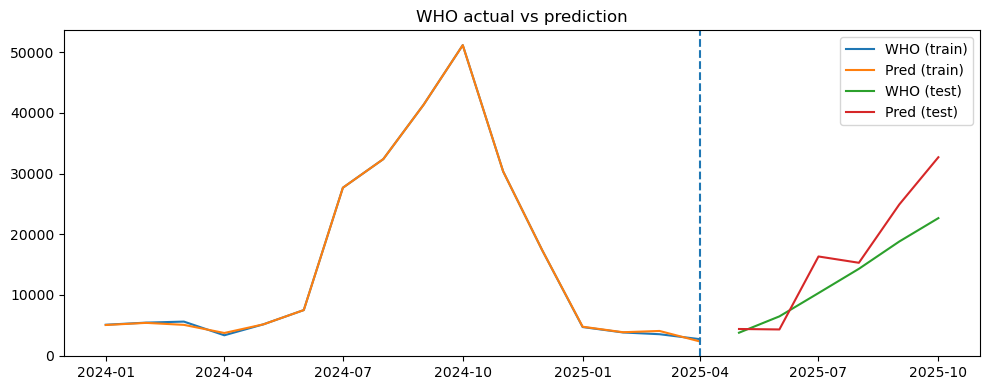

(               WHO         pred
 date                           
 2024-01-01  5079.0  5035.909960
 2024-02-01  5429.0  5389.042948
 2024-03-01  5597.0  5058.974121
 2024-04-01  3342.0  3719.856860
 2024-05-01  5145.0  5145.031063,
                 WHO          pred
 date                             
 2025-06-01   6459.0   4302.360837
 2025-07-01  10302.0  16336.721877
 2025-08-01  14303.0  15296.986842
 2025-09-01  18803.0  24910.920373
 2025-10-01  22659.0  32700.427198)

In [9]:
# Plot actual vs predicted

plt.figure(figsize=(10, 4))
plt.plot(y_train.index, y_train.values, label='WHO (train)')
plt.plot(y_train.index, pred_train, label='Pred (train)')
plt.plot(y_test.index, y_test.values, label='WHO (test)')
plt.plot(y_test.index, pred_test, label='Pred (test)')
plt.axvline(pd.to_datetime(cfg.split_month + '-01'), linestyle='--')
plt.title('WHO actual vs prediction')
plt.legend()
plt.tight_layout()
plt.show()

pred_df = pd.DataFrame({'WHO': y_proc, 'pred': pd.Series(best_model.predict(pd.concat([X_train_f, X_test_f])), index=pd.concat([X_train_f, X_test_f]).index)})
pred_df.head(), pred_df.tail()
